In [1]:
import os
parent_path = os.path.dirname(os.getcwd())
os.chdir(parent_path)

In [2]:
from utils.dataloader import GraphTextDataset, GraphDataset, TextDataset
from sklearn.metrics import silhouette_score
from torch_geometric.data import DataLoader
# from models.Model import BaseModel
from models.model2 import GAT_MLP
# from models.model3_transfert_learning import GAT_MLP_TL
import numpy as np
from transformers import AutoTokenizer
import torch
from torch import optim
import time
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.variables import ROOT_DIR
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

torch.cuda.empty_cache()

In [3]:
train = pd.read_csv(ROOT_DIR + '/data/train.tsv', sep='\t', header=None)
sample_train = train.sample(6000, random_state=42)
sample_train.to_csv(ROOT_DIR + '/data/sample_train.tsv', sep='\t', header=False, index=False)

model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
val_dataset = GraphTextDataset(root='./data/', gt=gt, split='val', tokenizer=tokenizer)
train_dataset = GraphTextDataset(root='./data/', gt=gt, split='sample_train', tokenizer=tokenizer)

In [4]:
# loading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(ROOT_DIR + '/logs/model_20241127_171613.pt')
model = GAT_MLP(model_name=model_name, num_node_features=300, nout=768, nhid=300, graph_hidden_channels=300) 
model.load_state_dict(checkpoint)
model.to(device)

/tmp/ipykernel_2119176/1274117589.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ROOT_DIR + '/logs/model_20241127_171613.pt')
2024-12-03 15:30:4

GAT_MLP(
  (graph_encoder): GraphEncoder(
    (relu): ReLU()
    (ln): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (conv1): GATConv(300, 300, heads=1)
    (conv2): GATConv(300, 300, heads=1)
    (conv3): GATConv(300, 300, heads=1)
    (mol_hidden1): Linear(in_features=300, out_features=300, bias=True)
    (mol_hidden2): Linear(in_features=300, out_features=768, bias=True)
  )
  (text_encoder): TextEncoder(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31090, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_featur

In [5]:
data_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

model.eval()
count = 0 

graphs_embedding = []
texts_embedding = []
for batch in data_loader:
    count +=1
    input_ids = batch.input_ids
    batch.pop('input_ids')
    attention_mask = batch.attention_mask
    batch.pop('attention_mask')
    graph_batch = batch
    
    x_graph, x_text = model(graph_batch.to(device), 
                            input_ids.to(device), 
                            attention_mask.to(device))
    
    x_graph = x_graph.detach().cpu()
    x_text = x_text.detach().cpu()

    graphs_embedding.append(x_graph)
    texts_embedding.append(x_text)

graphs_embedding = torch.cat(graphs_embedding, dim=0)
texts_embedding = torch.cat(texts_embedding, dim=0)

texts = pd.DataFrame(val_dataset.description)
graph_df = pd.DataFrame(graphs_embedding.numpy(), columns=[f'graph_emb_{i}' for i in range(graphs_embedding.shape[1])], index=texts.index)
text_df = pd.DataFrame(texts_embedding.numpy(), columns=[f'text_emb_{i}' for i in range(texts_embedding.shape[1])], index=texts.index)

/Data/victor.zhuang/Code/MIT/env/lib64/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Data/victor.zhuang/Code/Molecule Retrieval/utils/dataloader.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wh

In [6]:
graphs_embedding_normalized = (graph_df - graph_df.mean()) / graph_df.std()
texts_embedding_normalized = (text_df - text_df.mean()) / text_df.std()

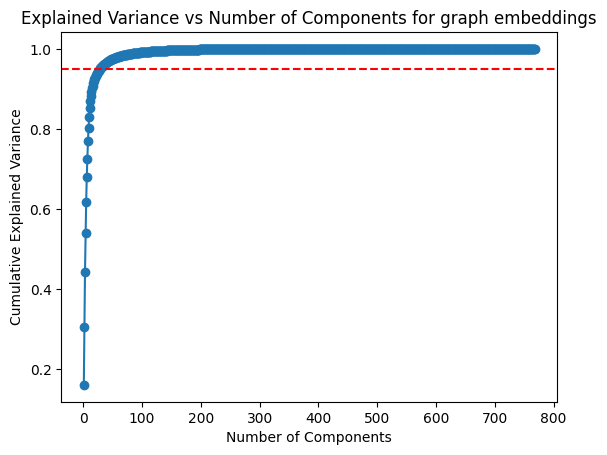

Number of components to retain 95% variance: 29


In [7]:
# Example dataset (X)
pca = PCA()
X_pca = pca.fit_transform(graphs_embedding_normalized)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold
plt.title('Explained Variance vs Number of Components for graph embeddings')
plt.show()

# Find the number of components that explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

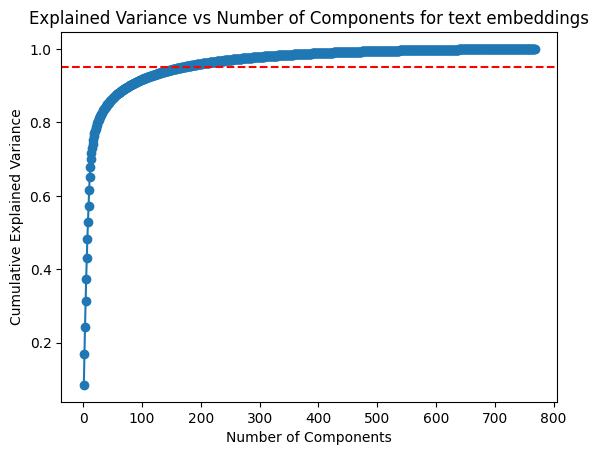

Number of components to retain 95% variance: 169


In [8]:
# Example dataset (X)
pca = PCA()
X_pca = pca.fit_transform(texts_embedding_normalized)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% threshold
plt.title('Explained Variance vs Number of Components for text embeddings')
plt.show()

# Find the number of components that explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

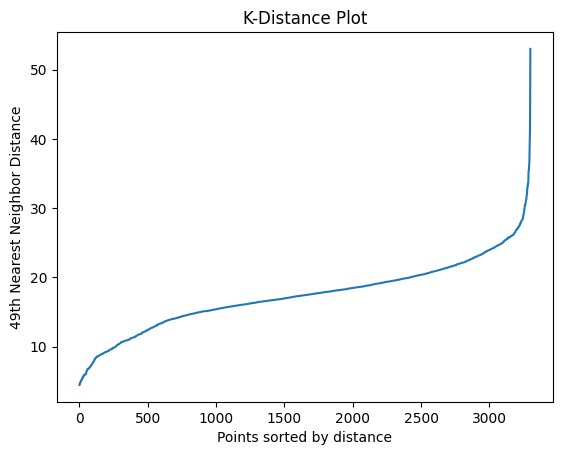

In [9]:
pca = PCA(n_components=30, random_state=42)
pca_graphs = pca.fit_transform(graphs_embedding_normalized)

min_samples = 50

# Assuming `X` is your dataset
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples - 1)  # k = min_samples - 1
nearest_neighbors.fit(pca_graphs)
distances, indices = nearest_neighbors.kneighbors(pca_graphs)
# Sort distances
distances = np.sort(distances[:, -1])  # Take the maximum distance to the 4th neighbor
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples -1}th Nearest Neighbor Distance")
plt.title("K-Distance Plot")
plt.show()

/tmp/ipykernel_2119176/2983196421.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


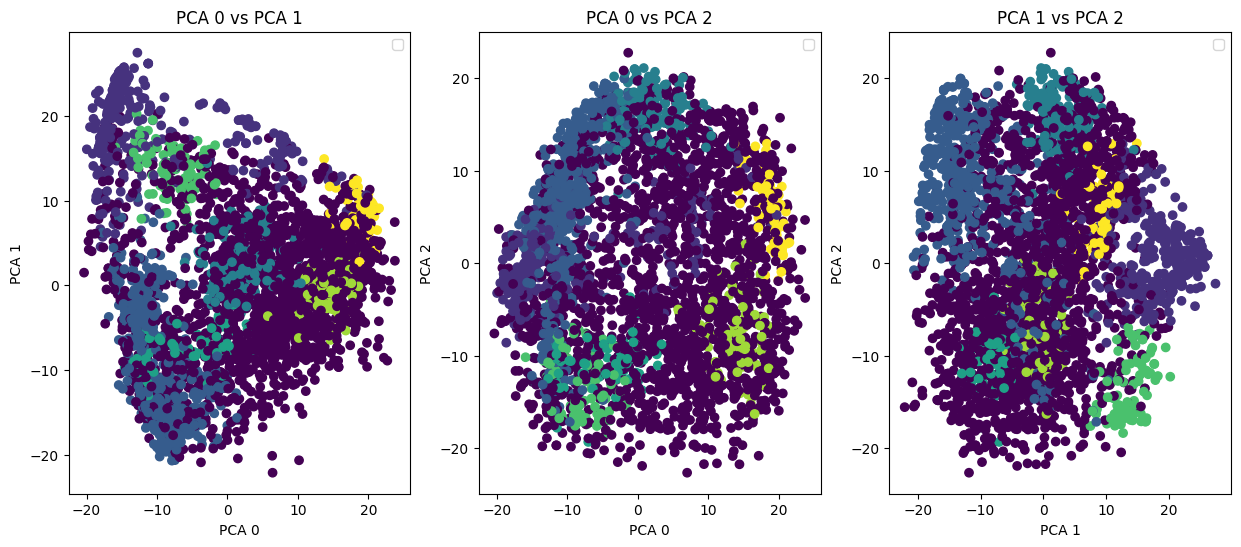

In [10]:
eps = 14
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(pca_graphs)


plt.figure(figsize=(15,6))
for i in range(3):
    for j in range(i+1, 3):
        plt.subplot(1,3, i+j)
        plt.scatter(pca_graphs[:, i], pca_graphs[:, j], c=dbscan.labels_)
        plt.xlabel(f'PCA {i}')
        plt.ylabel(f'PCA {j}')
        plt.title(f'PCA {i} vs PCA {j}')
        plt.legend()
plt.show()


In [11]:
# number of points in each cluster
unique, counts = np.unique(dbscan.labels_, return_counts=True)
display(dict(zip(unique, counts)))
labels = pd.DataFrame(dbscan.labels_, columns=['cluster_graph'], index=texts.index)

{-1: 1912, 0: 355, 1: 584, 2: 143, 3: 72, 4: 94, 5: 85, 6: 56}

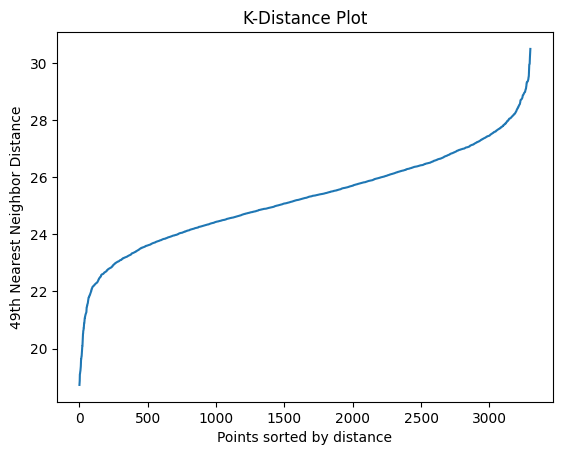

In [12]:
pca = PCA(n_components=170, random_state=42)
pca_text = pca.fit_transform(texts_embedding_normalized)

min_samples = 50

# Assuming `X` is your dataset
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples - 1)  # k = min_samples - 1
nearest_neighbors.fit(pca_text)
distances, indices = nearest_neighbors.kneighbors(pca_text)
# Sort distances
distances = np.sort(distances[:, -1])  # Take the maximum distance to the 4th neighbor
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples -1}th Nearest Neighbor Distance")
plt.title("K-Distance Plot")
plt.show()

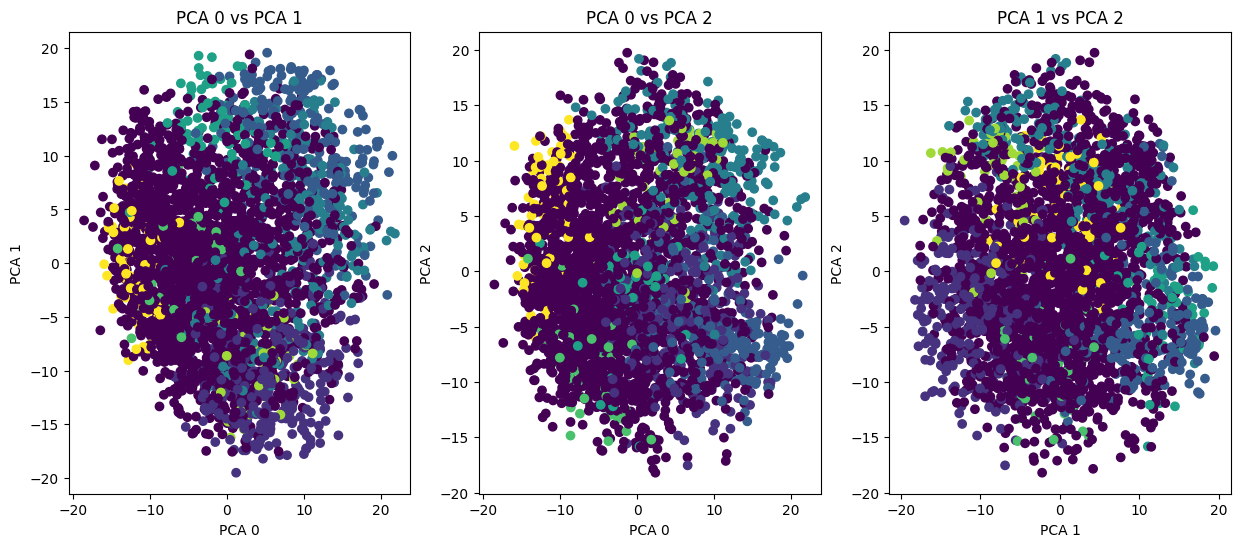

In [13]:
eps = 22.5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(pca_text)

plt.figure(figsize=(15,6))
for i in range(3):
    for j in range(i+1, 3):
        plt.subplot(1,3, i+j)
        plt.scatter(pca_text[:, i], pca_text[:, j], c=dbscan.labels_)
        plt.xlabel(f'PCA {i}')
        plt.ylabel(f'PCA {j}')
        plt.title(f'PCA {i} vs PCA {j}')
plt.show()

In [14]:
# number of points in each cluster
unique, counts = np.unique(dbscan.labels_, return_counts=True)
display(dict(zip(unique, counts)))
labels['cluster_text'] = dbscan.labels_

{-1: 2232, 0: 340, 1: 249, 2: 234, 3: 74, 4: 45, 5: 53, 6: 74}

In [15]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

new_labels = labels.loc[(labels['cluster_graph'] != -1) & (labels['cluster_text'] != -1)]
# new_labels = labels
print(adjusted_rand_score(new_labels['cluster_graph'], new_labels['cluster_text']))
print(normalized_mutual_info_score(new_labels['cluster_graph'], new_labels['cluster_text']))

0.7162820794926957
0.7562859851041757


In [16]:
print('The silouhette score for text embedding is: ', silhouette_score(texts_embedding_normalized.loc[(labels['cluster_graph'] != -1) & (labels['cluster_text'] != -1)], new_labels['cluster_text']))
print('The silouhette score for graph embedding is: ', silhouette_score(graphs_embedding_normalized.loc[(labels['cluster_graph'] != -1) & (labels['cluster_text'] != -1)], new_labels['cluster_graph']))

The silouhette score for text embedding is:  0.17348379
The silouhette score for graph embedding is:  0.31799713


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

processed_texts = []
for text in texts[1]:
    text = text.replace("-", " ")
    processed_texts.append(' '.join([word for word in text.lower().split() if word not in stop_words]))

# remove punctuation
processed_texts = [''.join([char for char in text if char not in string.punctuation]) for text in processed_texts]

tfidf = TfidfVectorizer(max_features=250)
tfidf_matrix = tfidf.fit_transform(processed_texts)
tfidf_matrix = tfidf_matrix.toarray()

In [18]:
from sklearn.linear_model import RidgeClassifierCV

normalized_tfidf = (tfidf_matrix - tfidf_matrix.mean()) / tfidf_matrix.std()
normalized_tfidf = normalized_tfidf[(labels['cluster_graph'] != -1) & (labels['cluster_text'] != -1)]

ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)
ridge.fit(normalized_tfidf[:-200], new_labels['cluster_graph'][:-200])

/Data/victor.zhuang/Code/MIT/env/lib64/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


RidgeClassifierCV(alphas=[0.001, 0.01, 0.1, 1], cv=5)

In [19]:
print(ridge.score(normalized_tfidf[:-200], new_labels['cluster_graph'][:-200]))

0.8463203463203464


In [20]:
print(ridge.score(normalized_tfidf[-200:], new_labels['cluster_graph'][-200:]))

0.325


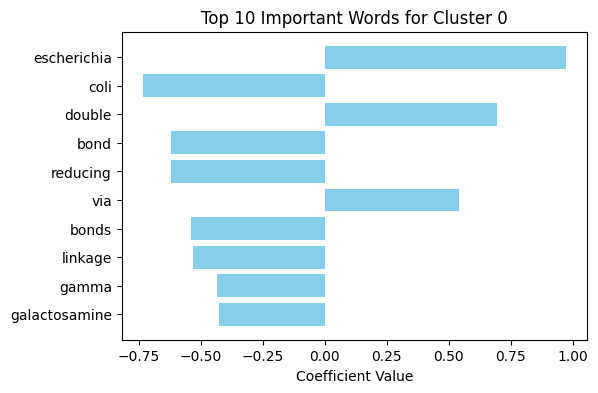

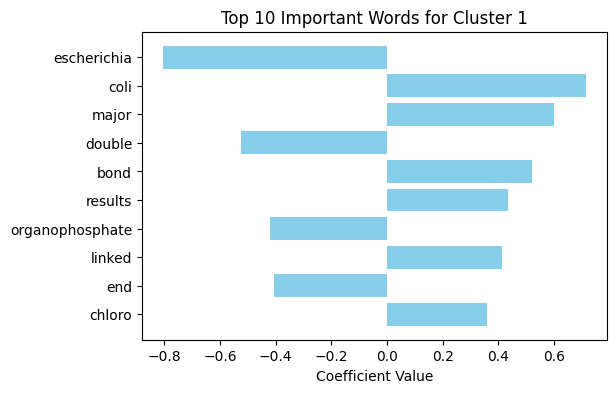

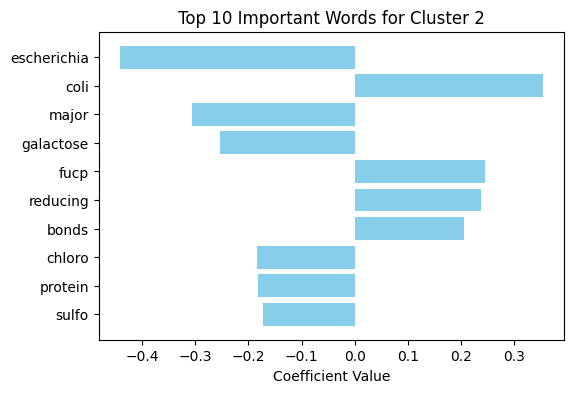

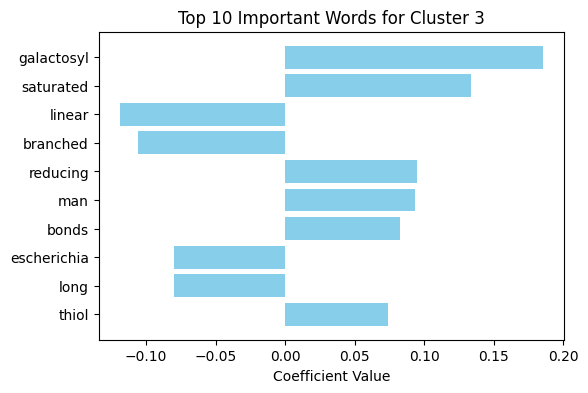

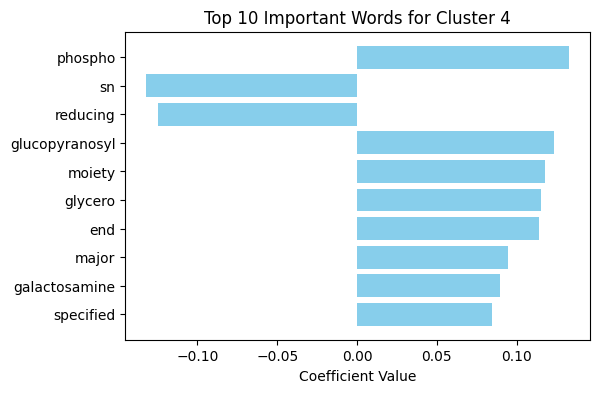

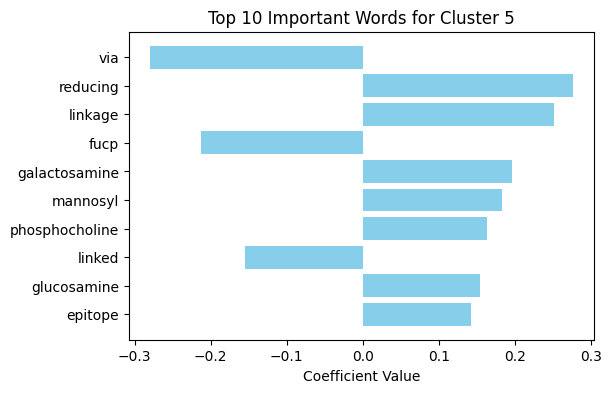

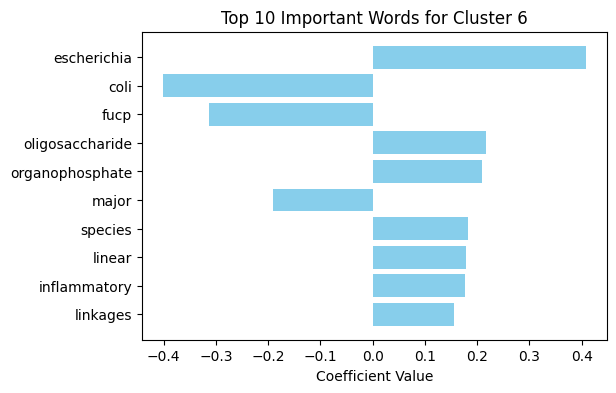

In [21]:
ridge_coeffs = pd.DataFrame(ridge.coef_, columns=tfidf.get_feature_names_out())

WORDS = []
for cluster in range(ridge_coeffs.shape[0]):
    top_words = ridge_coeffs.abs().iloc[cluster].nlargest(10).index
    top_values = ridge_coeffs.iloc[cluster][top_words].values
    plt.figure(figsize=(6, 4))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Important Words for Cluster {cluster}')
    plt.gca().invert_yaxis()
    plt.show()
    WORDS.append(top_words.to_list())

In [22]:
ridge_coeffs

,10,11,12,13,14,15,16,17,1d,1h,...,trisaccharide,triterpenoid,tryptophan,two,unsaturated,used,via,xenobiotic,yl,zwitterion
0,0.031431,0.020196,-0.010420,0.023852,-0.161611,-0.032137,-0.016132,-0.067853,0.319270,0.022705,...,0.183169,-0.038982,0.107985,0.213978,-0.001035,0.193449,0.540469,0.084483,-0.037307,0.011575
1,0.040808,-0.083518,-0.107774,-0.013395,0.086223,-0.062868,0.097084,0.075014,-0.150765,-0.068273,...,-0.289876,0.049057,-0.071031,-0.110094,0.011510,-0.059413,-0.186119,-0.093547,0.057477,-0.058461
2,-0.012609,0.116514,0.022778,0.019927,-0.080355,0.007252,0.054655,-0.011342,-0.110479,-0.021287,...,0.104180,0.044003,-0.004576,-0.085640,-0.054605,-0.058237,0.064694,-0.014999,-0.012430,0.026270
3,0.002357,-0.011864,0.002615,-0.004221,0.003129,-0.000993,0.011532,0.007963,-0.028642,-0.013048,...,0.032474,0.003409,-0.010301,0.004460,0.006994,0.019682,-0.006669,-0.029956,-0.004581,0.001230
4,-0.007307,-0.006938,-0.004960,0.001184,0.013351,0.005857,-0.015400,0.000600,0.026294,0.026683,...,-0.001439,-0.014589,0.000059,0.003201,-0.000141,0.013408,-0.032646,-0.006541,-0.003718,-0.006361
5,-0.010085,-0.033997,0.000842,0.006469,0.009195,0.003950,-0.033387,-0.009342,0.034069,0.040883,...,0.056584,-0.040195,-0.008052,-0.056430,0.005524,-0.002422,-0.279506,0.019251,-0.012012,0.028656
6,-0.044595,-0.000393,0.096919,-0.033815,0.130067,0.078940,-0.098353,0.004961,-0.089748,0.012337,...,-0.085091,-0.002703,-0.014084,0.030526,0.031752,-0.106468,-0.100223,0.041309,0.012571,-0.002909


In [35]:
def discrepency_score(word, cluster):
    score = 0
    for j in range(ridge_coeffs.shape[0]):
        if j != cluster:
            score += abs(ridge_coeffs.loc[cluster, word] - ridge_coeffs.loc[j, word])
    return score

In [43]:
# Create a dataframe with the top 10 words for each cluster
top_words_df = pd.DataFrame()
for cluster in range(ridge_coeffs.shape[0]):
    discrepancy_scores = pd.Series({word: discrepency_score(word, cluster) for word in ridge_coeffs.columns})
    top_words = discrepancy_scores.nlargest(40).index
    top_words_df[f'Cluster {cluster}'] = top_words

top_words_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,escherichia,escherichia,escherichia,escherichia,escherichia,escherichia,escherichia
1,coli,coli,coli,coli,coli,coli,coli
2,double,major,major,double,reducing,via,fucp
3,bond,double,galactose,bond,major,reducing,major
4,reducing,bond,reducing,reducing,double,linkage,organophosphate
5,via,results,fucp,galactosyl,bond,double,oligosaccharide
6,bonds,organophosphate,double,major,linkage,fucp,bond
7,linkage,linked,bonds,linkage,bonds,bond,double
8,gamma,end,via,via,via,galactosamine,linear
9,galactosamine,chloro,results,organophosphate,organophosphate,major,galactosamine


In [44]:
# merge the top words into 1 list
top_words = []
for i in range(top_words_df.shape[0]):
    top_words.extend(top_words_df.iloc[i].values)
top_words = list(set(top_words))
top_words = np.unique(np.array(top_words))

In [46]:
len(top_words)

87

In [47]:
pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names_out())[top_words].to_csv("tf_idf_matrix.csv", index=False)
labels.to_csv("labels.csv", index=False)

In [ ]:
# WORDS = np.unique(np.array(WORDS).flatten())
# pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names_out())[WORDS].to_csv("tf_idf_matrix.csv", index=False)
# labels.to_csv("labels.csv", index=False)

Without normalizing but with reweighting:

In [48]:
new_matrix = tfidf_matrix[(labels['cluster_graph'] != -1) & (labels['cluster_text'] != -1)]
ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)
ridge.fit(new_matrix, new_labels['cluster_graph'])
# print(ridge.score(tfidf_matrix[:-200], new_labels['cluster_graph'][:-200]))
# print(ridge.score(tfidf_matrix[-200:], new_labels['cluster_graph'][-200:]))

RidgeClassifierCV(alphas=[0.001, 0.01, 0.1, 1], cv=5)

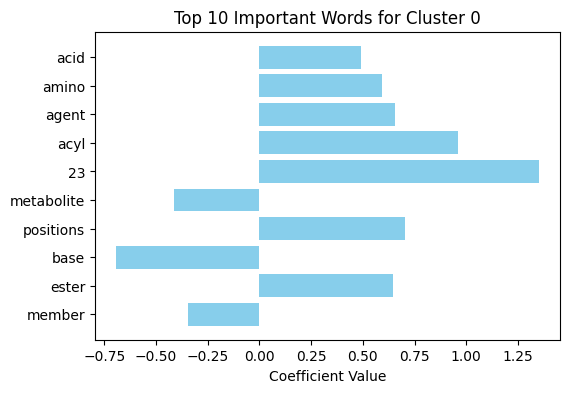

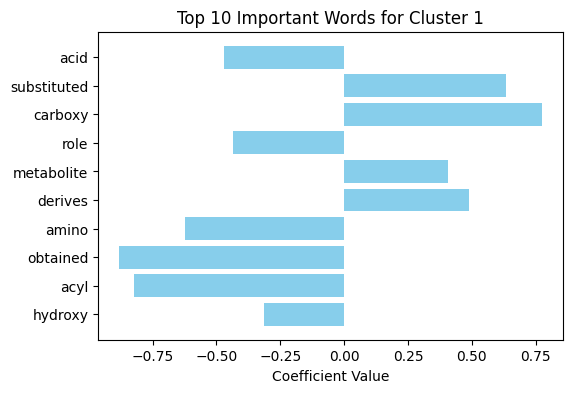

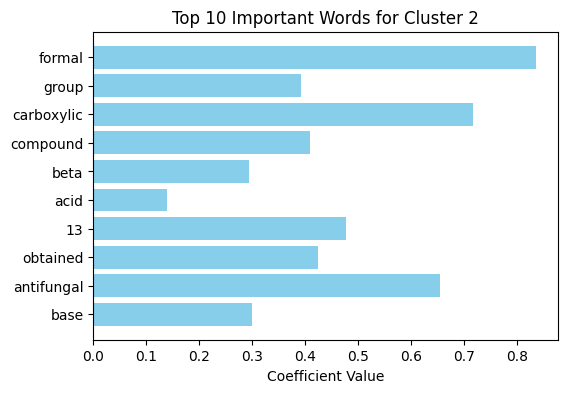

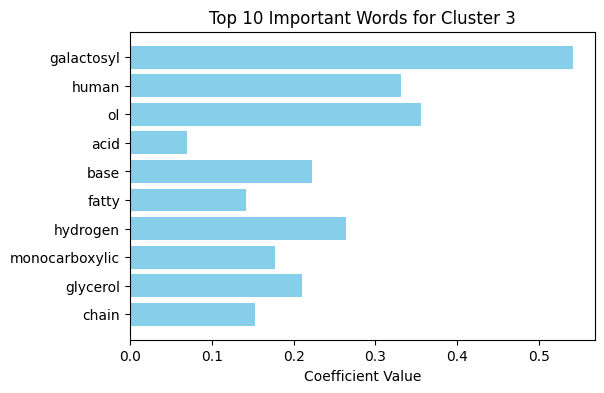

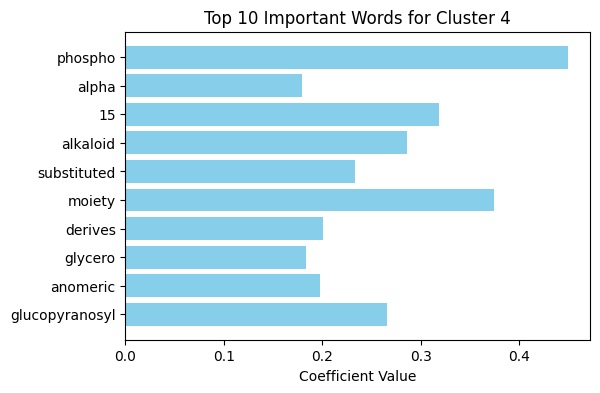

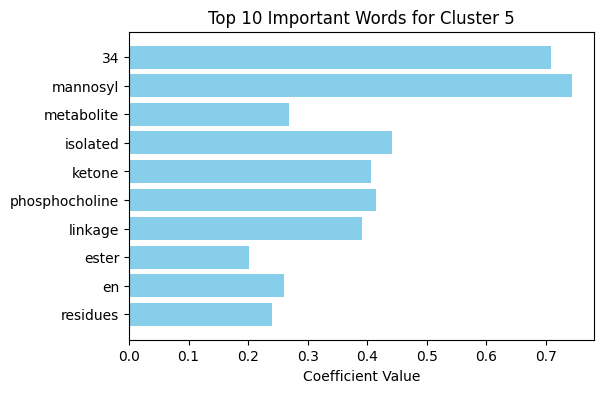

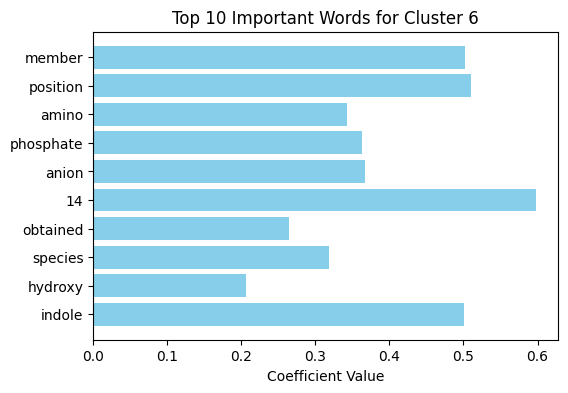

In [49]:
ridge_coeffs = pd.DataFrame(ridge.coef_, columns=tfidf.get_feature_names_out())

for cluster in range(ridge_coeffs.shape[0]):
    top_words = (ridge_coeffs.iloc[cluster] * new_matrix[new_labels['cluster_graph'] == cluster].mean(axis=0)).abs().nlargest(10).index
    top_values = ridge_coeffs.iloc[cluster][top_words].values
    plt.figure(figsize=(6, 4))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Important Words for Cluster {cluster}')
    plt.gca().invert_yaxis()
    plt.show()

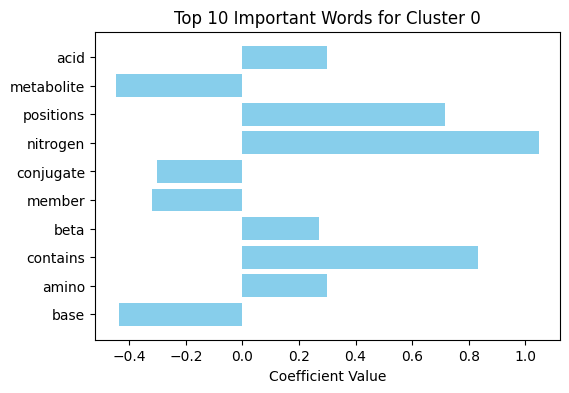

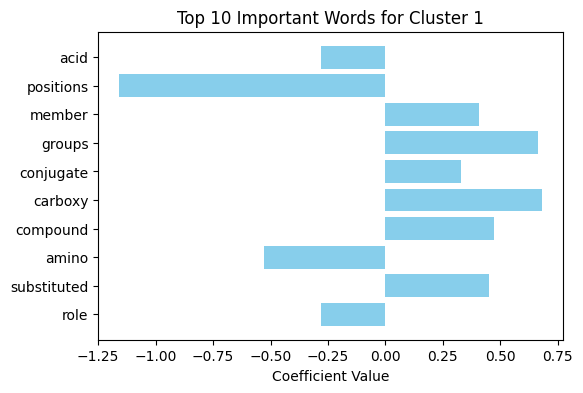

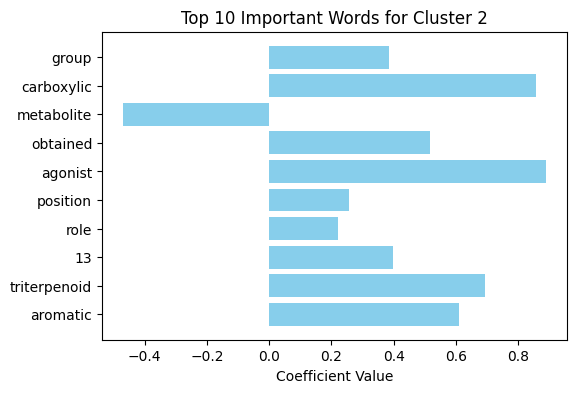

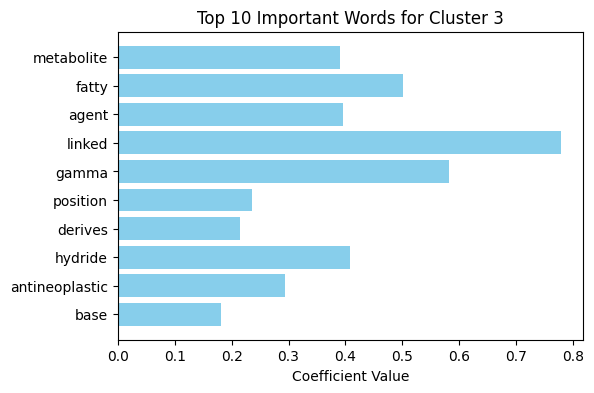

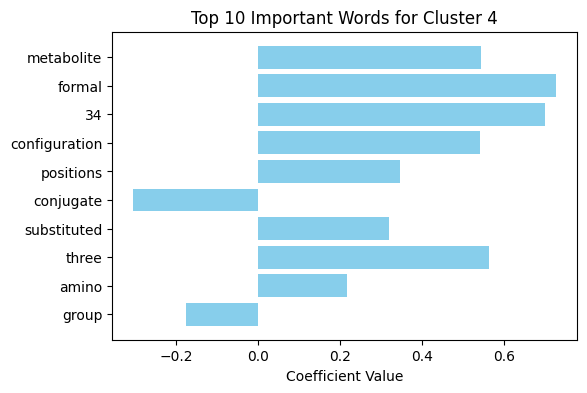

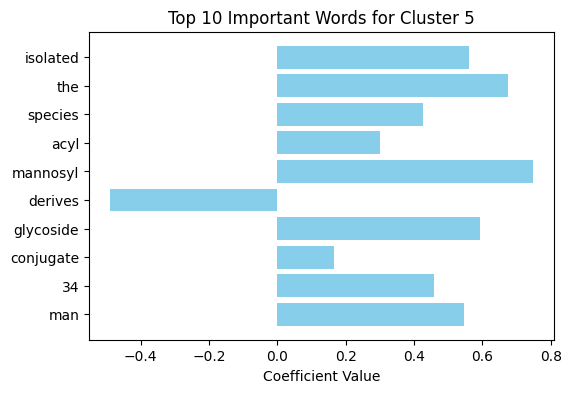

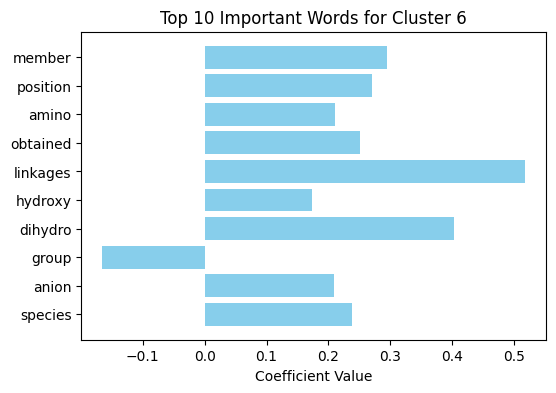

In [50]:
new_matrix = tfidf_matrix[(labels['cluster_graph'] != -1)]
ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5)
ridge.fit(new_matrix,labels['cluster_graph'][labels['cluster_graph']!=-1])

ridge_coeffs = pd.DataFrame(ridge.coef_, columns=tfidf.get_feature_names_out())

for cluster in range(ridge_coeffs.shape[0]):
    top_words = (ridge_coeffs.iloc[cluster] * tfidf_matrix[labels['cluster_graph'] == cluster].mean(axis=0)).abs().nlargest(10).index
    top_values = ridge_coeffs.iloc[cluster][top_words].values
    plt.figure(figsize=(6, 4))
    plt.barh(top_words, top_values, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 10 Important Words for Cluster {cluster}')
    plt.gca().invert_yaxis()
    plt.show()